In [ ]:
#import libaries
from deepface import DeepFace
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
from bs4 import BeautifulSoup
import csv

✅ Saved 2 faces successfully!
25-02-27 12:54:33 - Searching D:\GitHub\Movie Shazam\Face Rec\API_Programs\detected_faces/face_0.jpg in 869 length datastore
25-02-27 12:54:34 - find function duration 0.3834648132324219 seconds
25-02-27 12:54:34 - Searching D:\GitHub\Movie Shazam\Face Rec\API_Programs\detected_faces/face_1.jpg in 869 length datastore
25-02-27 12:54:34 - find function duration 0.34847593307495117 seconds

🔍 Matching Results:
                                             identity  distance  threshold
0   D:\GitHub\Movie Shazam\Face Rec\API_Programs\a...  0.573499       1.04
1   D:\GitHub\Movie Shazam\Face Rec\API_Programs\a...  0.578306       1.04
2   D:\GitHub\Movie Shazam\Face Rec\API_Programs\a...  0.616291       1.04
3   D:\GitHub\Movie Shazam\Face Rec\API_Programs\a...  0.709339       1.04
4   D:\GitHub\Movie Shazam\Face Rec\API_Programs\a...  0.767848       1.04
5   D:\GitHub\Movie Shazam\Face Rec\API_Programs\a...  0.814783       1.04
6   D:\GitHub\Movie Shazam\Face R

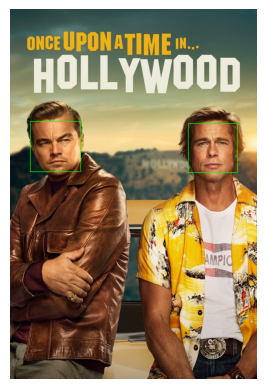

In [ ]:


# Input image path (group photo)
img_path = r"D:\GitHub\Movie Shazam\Face Rec\API_Programs\test_images\wQKeS2JrsRF8XSfd9zqflrc5gad.jpg"

# Face database path
db_path = r"D:\GitHub\Movie Shazam\Face Rec\API_Programs\actors_DB"

# Create a directory to store cropped faces
output_dir = "D:\GitHub\Movie Shazam\Face Rec\API_Programs\detected_faces"
os.makedirs(output_dir, exist_ok=True)

# Step 1: Detect Multiple Faces
faces = DeepFace.extract_faces(img_path, enforce_detection=False, detector_backend="opencv")

detected_faces = []
face_bounding_boxes = []  # Store bounding boxes separately

for i, face in enumerate(faces):
    # Convert face image to numpy array
    face_array = np.array(face["face"])

    # Convert from float64 (0-1) to uint8 (0-255)
    face_array = (face_array * 255).astype(np.uint8)

    # Save cropped face
    face_path = f"{output_dir}/face_{i}.jpg"
    cv2.imwrite(face_path, cv2.cvtColor(face_array, cv2.COLOR_RGB2BGR))

    detected_faces.append(face_path)
    face_bounding_boxes.append(face["facial_area"])  # Store bounding box for later

print(f"✅ Saved {len(detected_faces)} faces successfully!")

# Step 2: Match Each Face Against the Database
results = []
for face_path in detected_faces:
    df = DeepFace.find(
        img_path=face_path,
        db_path=db_path,
        enforce_detection=False,
        model_name="Facenet512",  # ✅ Faster model
        detector_backend="opencv",  # ✅ Faster face detector
        distance_metric="euclidean_l2",  # ✅ Less computationally expensive
        silent=False  # ✅ Doesnt Suppress logs
    )
    if len(df) > 0:
        results.append(df[0])  # Append first match

# Merge all results into a single DataFrame
df_results = pd.concat(results) if results else pd.DataFrame()
print("\n🔍 Matching Results:")
print(df_results[["identity", "distance", "threshold"]])

# Step 3: Filter and Keep Only the Best Matches per Person
best_matches = df_results[df_results["distance"] < df_results["threshold"]]

# Extract unique best matches per person
unique_best_matches = {}
for identity_path, distance in zip(best_matches["identity"], best_matches["distance"]):
    person_name = os.path.basename(os.path.dirname(identity_path))  # Extract folder name

    # Store only the first occurrence of each person
    if person_name not in unique_best_matches:
        unique_best_matches[person_name] = (identity_path, distance)

# Sort matches by distance (best match first)
unique_best_matches_sorted = sorted(unique_best_matches.items(), key=lambda x: x[1][1])

# Extract only the names for display
best_match_names = [name for name, _ in unique_best_matches_sorted]
print("\n✅ Unique Best Match Names:")
print(best_match_names)

# Step 4: Draw Bounding Boxes and Overlay Names on the Original Image
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Dictionary to store face bounding boxes with matched names
identity_map = {v[0]: k for k, v in unique_best_matches.items()}  # {image_path: person_name}

# Draw bounding boxes and annotate identities
for (face_box, face_path) in zip(face_bounding_boxes, detected_faces):
    x, y, w, h = face_box["x"], face_box["y"], face_box["w"], face_box["h"]

    # Draw bounding box
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Find the matched identity (folder name)
    matched_identity = None
    for identity_path, person_name in identity_map.items():
        if os.path.basename(identity_path) in face_path:
            matched_identity = person_name

    # Display the name above the face
    if matched_identity:
        cv2.putText(image, matched_identity, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Display the image with bounding boxes and labels
plt.imshow(image)
plt.axis("off")
plt.show()
